UNET for Multi-class Segmentation of Brain Tumors (meningioma, glioma, pituitary tumor)

NOTE: Restart the Python kernel between runs to clear the state

Pip Install all Packages via Terminal in the Correct activated VENV
OR !pip install package below if Jupyter

VENV for local installs: source SPR24ENV/bin/activate 
VENV for cluster installs: source UNETvenv/bin/activate 

In [554]:
import os
import sys
import numpy as np
import pandas as pd
import cv2  # opencv+python == 4.9.0.80 # image processing
import matplotlib.pyplot as plt
import hdf5storage  # 0.1.19 # for loading .mat files

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf # Ensure using 2.13.0 as mentioned
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Conv2DTranspose, BatchNormalization, Activation)
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers.legacy import Adam # trying legacy Adam for better performance
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator # optional data augmentation

import seaborn as sns

Ensure GPU is Connected for Local & Cluster Runs

In [555]:
# local check
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available; TensorFlow is using CPU")

# cluster check

GPU is available


Data Loading

In [556]:
path = '/' # local runs
data_dir = os.path.join(path, 'data') # local runs
# data_dir = '/' # cluster runs

if not os.path.isdir(data_dir):
    raise FileNotFoundError(f"No such directory: {data_dir}") # debug check

files = os.listdir(data_dir)
print(f"Files in {data_dir}:", files) # should see ~2000 mat files from Cheng 2016 dataset

Files in /data: ['113.mat', '107.mat', '106.mat', '112.mat', '104.mat', '110.mat', '39.mat', '38.mat', '111.mat', '105.mat', '101.mat', '115.mat', '129.mat', '28.mat', '29.mat', '128.mat', '114.mat', '100.mat', '116.mat', '102.mat', '103.mat', '117.mat', '99.mat', '98.mat', '957.mat', '88.mat', '89.mat', '956.mat', '968.mat', '48.mat', '49.mat', '955.mat', '2292.mat', '964.mat', '958.mat', '93.mat', '87.mat', '44.mat', '45.mat', '86.mat', '92.mat', '959.mat', '965.mat', '2293.mat', '2291.mat', '967.mat', '84.mat', '90.mat', '47.mat', '46.mat', '91.mat', '85.mat', '966.mat', '2294.mat', '962.mat', '81.mat', '95.mat', '42.mat', '43.mat', '94.mat', '963.mat', '2295.mat', '2297.mat', '961.mat', '96.mat', '82.mat', '41.mat', '40.mat', '83.mat', '97.mat', '960.mat', '2296.mat', '132.mat', '126.mat', '33.mat', '27.mat', '32.mat', '127.mat', '133.mat', '119.mat', '125.mat', '131.mat', '30.mat', '31.mat', '130.mat', '124.mat', '118.mat', '120.mat', '134.mat', '108.mat', '35.mat', '34.mat', '109

Data Preprocessing Pipeline

Sample = Pixel
- every pixel is treated separately and hails from the original images

Input: 512 x 512 images

- each mask will be labeled according to the tumor type (each class is represented by different integer labels in the mask)
- labels 1, 2, and 3 correspond to meningioma, glioma, and pituitary tumor respectively
- include one-hot encoding for masks to ensure each mask is transformed into a binary format suitable for multi-class segmentation using categorical crossentropy in training/model architecture

1. Normalize pixel values
2. Create label classes for the 3 tumors
3. Make sure data types match as float32 for images and masks

Total files found: 99
[90/99] images loaded: 90.9 %
Finished loading and processing data. Successfully processed 99/99 files.


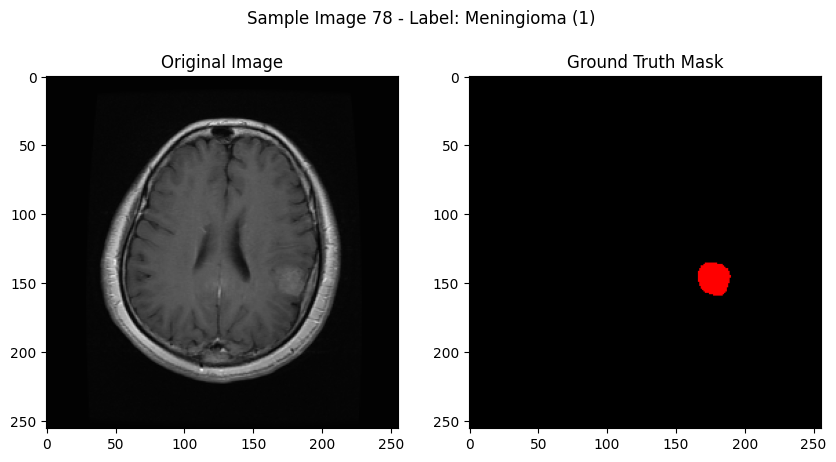

Label 1 (Type): 78 slices, 78.79% of the dataset
Label 3 (Type): 14 slices, 14.14% of the dataset
Label 2 (Type): 7 slices, 7.07% of the dataset
Data type of image: float32
Data type of masks: float32


In [557]:
def load_and_preprocess_data(data_dir, image_dimension=256):
    images = []
    masks = []
    labels = []  # Store labels to check distribution
    files = os.listdir(data_dir)

    # Data integrity check
    print(f"Total files found: {len(files)}")
    processed_count = 0

    for i, file in enumerate(files, start=1):
        try:
            mat_file = hdf5storage.loadmat(os.path.join(data_dir, file))['cjdata'][0] # Load the .mat file
            
            # Resize and normalize the images
            image = mat_file['image']
            image = cv2.resize(image, dsize=(image_dimension, image_dimension), interpolation=cv2.INTER_CUBIC)
            image = image.astype(np.float32) / 255.0  # Scale image to range [0, 1]
            image = np.expand_dims(image, axis=-1)  # Add the channel dimension (fprep or check later)

            # Resize and prepare mask for multi-class segmentation
            mask = mat_file['tumorMask'].astype('uint8')
            mask = cv2.resize(mask, dsize=(image_dimension, image_dimension), interpolation=cv2.INTER_NEAREST)
            mask = np.expand_dims(mask, axis=-1)  # Add the channel dimension (prep for check later)

            # Get the label and convert to one-hot
            label = int(mat_file['label'])  # assuming label is directly accessible
            one_hot_mask = np.zeros((image_dimension, image_dimension, 3), dtype=np.float32)  # three classes # set dtype to float32
            for j in range(1, 4):  # labels are 1, 2, 3
                one_hot_mask[:, :, j-1] = (mask[:, :, 0] == j).astype(np.float32)  # Cast to float32

            # Append processed image and mask to their respective lists
            images.append(image)
            masks.append(one_hot_mask)
            #masks.append(mask)
            labels.append(label)
            processed_count += 1

            if i % 10 == 0:
                sys.stdout.write(f'\r[{i}/{len(files)}] images loaded: {i / float(len(files)) * 100:.1f} %')
                sys.stdout.flush()

        except Exception as e:
            print(f"Failed to process file {file}: {e}")
            
    print(f"\nFinished loading and processing data. Successfully processed {processed_count}/{len(files)} files.")
    return np.array(images), np.array(masks), np.array(labels)

def visualize_sample_images(images, masks, labels, num_samples=5):
    """Visual inspection of images and masks, with labels indicating tumor type."""
    # Mapping of label numbers to tumor names
    label_to_tumor = {1: 'Meningioma', 2: 'Glioma', 3: 'Pituitary Tumor'}
    
    indices = np.random.choice(len(images), num_samples, replace=False)
    for i in indices:
        # grab tumor type from label
        tumor_type = label_to_tumor.get(labels[i], "Unknown Tumor Type")
        title = f"Sample Image {i+1} - Label: {tumor_type} ({labels[i]})"
        show_image_and_mask(images[i], masks[i], title)

def check_data_distribution(labels):
    """Check for class distribution across different tumor types."""
    from collections import Counter
    label_counts = Counter(labels)
    total_counts = len(labels)
    for label, count in label_counts.items():
        print(f"Label {label} (Type): {count} slices, {count / total_counts * 100:.2f}% of the dataset")

def show_image_and_mask(image, mask, title):
    """Displays an image and its corresponding mask side by side."""
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Original Image')
    ax[1].imshow(mask, cmap='viridis')
    ax[1].set_title('Ground Truth Mask')
    plt.suptitle(title)
    plt.show()

data_dir = '/data' # local runs
# data_dir = '' # cluster runs
image_dimension = 256

# Func to load and preprocess the data
images, masks, labels = load_and_preprocess_data(data_dir, image_dimension)

# Visualization for sample images and masks
visualize_sample_images(images, masks, labels, num_samples=1) # best is 3

# Check data distribution for class imbalance
check_data_distribution(labels)

# Check data types of masks and predictions to make sure they're both float32
print(f"Data type of image: {images.dtype}")
print(f"Data type of masks: {masks.dtype}")

Check Dimensions Before Training (optional, recommended)

- MRI scans are generally single-channel (grayscale), where each pixel represents an intensity value.
- Lack of an explicit channel dimension in the arrays ((512, 512) instead of (512, 512, 1)) is common because the single channel is implicit in grayscale images.
- However, for processing in DL models like U-Net, we need to explicitly include the channel dimension.

- FOR IMAGES: typically single-channel for grayscale -> correct shape is (512, 512, 1) for DL processing
- FOR MASKS: for multi-class segmentation, especially when one-hot encoded with three classes (Meningioma, Glioma, Pituitary Tumor), should have shape (512, 512, 3) where each channel corresponds to one class

In [558]:
def check_dimensions(images, masks, required_image_shape, required_mask_shape):
    assert images[0].shape == required_image_shape, f"Image shape mismatch: expected {required_image_shape}, got {images[0].shape}"
    assert masks[0].shape == required_mask_shape, f"Mask shape mismatch: expected {required_mask_shape}, got {masks[0].shape}"
    print(f"Image shape is {images[0].shape} and mask shape is {masks[0].shape}.")
    print("All images and masks correctly match the required shapes.")

# Required shape for U-Net
required_image_shape = (256, 256, 1)  # for the images -> grayscale and should have a single channel explicitly
required_mask_shape = (256, 256, 3)   # for the masks -> which are one-hot encoded across three classes

check_dimensions(images, masks, required_image_shape, required_mask_shape)

Image shape is (256, 256, 1) and mask shape is (256, 256, 3).
All images and masks correctly match the required shapes.


Local Save (optional)

save_path = '/' # local runs
# save_path = '/' # cluster runs

np.save(os.path.join(save_path, 'images.npy'), images)
np.save(os.path.join(save_path, 'masks.npy'), masks)
np.save(os.path.join(save_path, 'labels.npy'), labels)

Splitting the dataset into Training, Validation and Test Set

- Split Training, Validation and Testing data
- 80% (60:20) training + validation -> data for learning and to tune the model's hyperparameters without overfitting
- 20% testing -> to evaluate model's performance on unseen data
- Using Single validation split strategy for less computation time/resources
- use 5-fold cross validation if computational resources allow

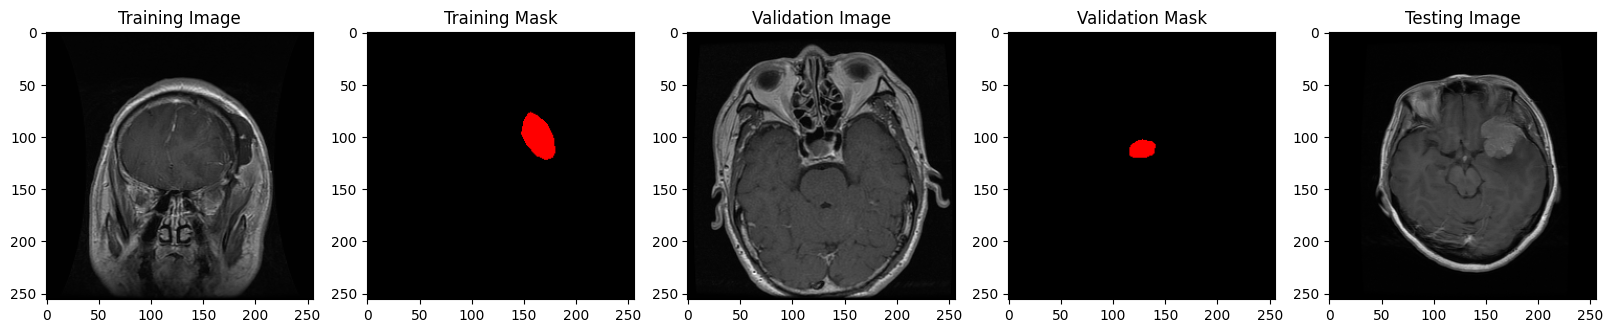

Total Label Distribution: {1: 78, 2: 7, 3: 14}
Training Label Distribution: {1: 46, 2: 5, 3: 8}
Validation Label Distribution: {1: 16, 2: 1, 3: 3}
Testing Label Distribution: {1: 16, 2: 1, 3: 3}
Data type of images_train: float32
Data type of masks_train: float32
Data type of labels_train: int64
Data type of images_val: float32
Data type of masks_val: float32
Data type of labels_val: int64
Data type of images_test: float32
Data type of masks_test: float32
Data type of labels_test: int64
Training Images shape: (59, 256, 256, 1)
Training Masks shape: (59, 256, 256, 3)
Validation Images shape: (20, 256, 256, 1)
Validation Masks shape: (20, 256, 256, 3)
Testing Images shape: (20, 256, 256, 1)
Testing Masks shape: (20, 256, 256, 3)


In [559]:
def split_data(images, masks, labels, test_size=0.2, val_size=0.2, random_state=42):
    """
    Split data into training, validation, and testing sets.
    - test_size specifies the proportion of the data for testing.
    - val_size specifies the proportion of the training data for validation.
    """
    images_train, images_test, masks_train, masks_test, labels_train, labels_test = train_test_split(
        images, masks, labels, test_size=test_size, random_state=random_state, stratify=labels)
    
    images_train, images_val, masks_train, masks_val, labels_train, labels_val = train_test_split(
        images_train, masks_train, labels_train, test_size=val_size, random_state=random_state, stratify=labels_train)

    return images_train, masks_train, labels_train, images_val, masks_val, labels_val, images_test, masks_test, labels_test

def check_distribution(labels, title="Label distribution"):
    """Print the distribution of labels."""
    unique, counts = np.unique(labels, return_counts=True)
    label_dict = dict(zip(unique, counts))
    print(f"{title}: {label_dict}")
    

def visualize_data_samples(images_train, masks_train, images_val, masks_val, images_test):
    """Display the first image and mask from training, validation, and testing sets."""
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    axes[0].imshow(images_train[0], cmap='gray')
    axes[0].set_title('Training Image')
    axes[1].imshow(masks_train[0], cmap='viridis')
    axes[1].set_title('Training Mask')
    axes[2].imshow(images_val[0], cmap='gray')
    axes[2].set_title('Validation Image')
    axes[3].imshow(masks_val[0], cmap='viridis')
    axes[3].set_title('Validation Mask')
    axes[4].imshow(images_test[0], cmap='gray')
    axes[4].set_title('Testing Image')
    plt.show()

# Split the data into training, validation, and testing sets
images_train, masks_train, labels_train, images_val, masks_val, labels_val, images_test, masks_test, labels_test = split_data(images, masks, labels, test_size=0.2, val_size=0.25)

# Visualization for the first training, validation, and testing images
visualize_data_samples(images_train, masks_train, images_val, masks_val, images_test)  # You might want to adjust this to include validation images.

# Check label distributions
check_distribution(labels, "Total Label Distribution")
check_distribution(labels_train, "Training Label Distribution")
check_distribution(labels_val, "Validation Label Distribution")
check_distribution(labels_test, "Testing Label Distribution")

# DEBUG: Check data types to make sure images and masks are float32, all labels can be int64
print(f"Data type of images_train: {images_train.dtype}")
print(f"Data type of masks_train: {masks_train.dtype}")
print(f"Data type of labels_train: {labels_train.dtype}")
print(f"Data type of images_val: {images_val.dtype}")
print(f"Data type of masks_val: {masks_val.dtype}")
print(f"Data type of labels_val: {labels_val.dtype}")
print(f"Data type of images_test: {images_test.dtype}")
print(f"Data type of masks_test: {masks_test.dtype}")
print(f"Data type of labels_test: {labels_test.dtype}")

print(f"Training Images shape: {images_train.shape}")
print(f"Training Masks shape: {masks_train.shape}")

print(f"Validation Images shape: {images_val.shape}")
print(f"Validation Masks shape: {masks_val.shape}")

print(f"Testing Images shape: {images_test.shape}")
print(f"Testing Masks shape: {masks_test.shape}")

data_sets = {
    'training': (images_train, masks_train),
    'validation': (images_val, masks_val),
    'testing': (images_test, masks_test)
}

Defining Metrics Stage

True Masks:
Shape: (batch_size, height, width, num_classes)

Predicted Masks:
Shape: (batch_size, height, width, num_classes)

(OPTIONAL) DEBUG CHECK: Verify the Metrics Calculatate as Expected inside Metrics.ipynb notebook) 

Dice Coefficient (dice_coef):
- Calculates Dice coefficients for each class.
- Returns both individual class scores and the mean Dice coefficient.

Intersection over Union (iou_coef):
- Calculates IoU coefficients for each class.
- Returns both individual class scores and the mean IoU coefficient.

Dice Loss (dice_loss):
- Calculates Dice loss for a single class from one-hot encoded masks.

Combined Loss (calculate_losses):
- Calculates the combined loss (categorical cross-entropy and Dice) per class and the mean loss.
- Uses user-defined weights for both loss terms.

Multi-Class Accuracy (calculate_accuracies):
- Calculates accuracy metrics for each class and the mean accuracy across all classes.

Regular Dice and Jaccard Metrics

- Dice coeffiecient -> calculates the overlap between the predicted and true masks in segmentation (0-1 score)
- IoU (jaccard) coeffiecient -> measures similarity/diversity between predicted and true masks (0-1 score)
- as coefficients we want to maximize them (the closer to 1 the better) 

note: 
- the loss is a training tool, not a direct measure of segmentation quality therefore we use the coefficients to do so
- coefficients are not influenced by combined loss function

In [560]:
def dice_coef(true_mask, pred_mask, smooth=1.0):
    """
    Calculates Dice coefficients for each class and returns individual and mean scores.

    Args:
        true_mask: Ground truth one-hot encoded segmentation mask (tensor).
        pred_mask: Predicted segmentation mask (tensor, might need reshaping).
        smooth: Smoothing factor to avoid division by zero (default 1.0).

    Returns:
        A tuple containing:
            - dice_scores: List of Dice coefficients for each class.
            - mean_dice: Mean Dice coefficient across all classes.
    """
    num_classes = true_mask.shape[-1]
    dice_scores = []
    for class_idx in range(num_classes):
        class_true_mask = true_mask[..., class_idx]  # Select mask for current class
        class_pred_mask = pred_mask[..., class_idx]  # Select mask for current class
        intersection = tf.reduce_sum(class_true_mask * class_pred_mask)
        sum_true_mask = tf.reduce_sum(class_true_mask)  # Vectorized sum for class
        sum_pred_mask = tf.reduce_sum(class_pred_mask)  # Vectorized sum for class
        dice_score = (2. * intersection + smooth) / (sum_true_mask + sum_pred_mask + smooth)
        dice_scores.append(dice_score)

    mean_dice = tf.reduce_mean(dice_scores)
    return dice_scores, mean_dice

def iou_coef(true_mask, pred_mask, smooth=1.0):
    """
    Calculates IoU coefficients for each class and returns individual and mean scores.

    Args:
        true_mask: Ground truth one-hot encoded segmentation mask (tensor).
        pred_mask: Predicted segmentation mask (tensor, might need reshaping).
        smooth: Smoothing factor to avoid division by zero (default 1.0).

    Returns:
        A tuple containing:
            - iou_scores: List of IoU coefficients for each class.
            - mean_iou: Mean IoU coefficient across all classes.
    """
    num_classes = true_mask.shape[-1]
    iou_scores = []
    for class_idx in range(num_classes):
        class_true_mask = true_mask[..., class_idx]  # get mask for current class
        class_pred_mask = pred_mask[..., class_idx]  # get mask for current class
        intersection = tf.reduce_sum(class_true_mask * class_pred_mask)
        sum_true_mask = tf.reduce_sum(class_true_mask)  # vectorized sum for class
        sum_pred_mask = tf.reduce_sum(class_pred_mask)  # vectorized sum for class
        union = sum_true_mask + sum_pred_mask - intersection
        iou_score = (intersection + smooth) / (union + smooth)
        iou_scores.append(iou_score)

    mean_iou = tf.reduce_mean(iou_scores)
    return iou_scores, mean_iou

Custom Combined Loss Func

- primary training loss function
- we want to minimize the loss (closer to 0 the better)
- categorical crossentropy + dice loss
- Dice loss -> minimizes difference between the predicted and true masks
- adjust the weighting/scales between categorical crossentropy and Dice loss to improve performance

Use only this loss function (mean loss not individual) in the model compilation/training

- in order to integrate with Keras (compatibility) need to return a single value for the loss during training only
- save individual loss calc for evaluation

In [561]:
def dice_loss(true_mask, pred_mask, smooth=1.0):
    intersection = tf.reduce_sum(true_mask * pred_mask)
    sum_true_mask = tf.reduce_sum(true_mask)
    sum_pred_mask = tf.reduce_sum(pred_mask)
    dice_loss_val = 1 - (2. * intersection + smooth) / (sum_true_mask + sum_pred_mask + smooth)
    return dice_loss_val

def calculate_losses(true_mask, pred_mask, num_classes=3, weight_ce=0.1, weight_dice=0.9):
    # Ensure the shapes are correct
    tf.print(f"Initial true_mask shape: {true_mask.shape}, dtype: {true_mask.dtype}")
    tf.print(f"Initial pred_mask shape: {pred_mask.shape}, dtype: {pred_mask.dtype}")

    if true_mask.shape[-1] == 1:
        true_mask = tf.squeeze(true_mask, axis=-1)
        true_mask = tf.one_hot(tf.cast(true_mask, tf.int32), depth=num_classes)
    elif true_mask.shape[-1] != num_classes:
        true_mask = tf.one_hot(tf.cast(true_mask, tf.int32), depth=num_classes)

    tf.print(f"One-hot encoded true_mask shape: {true_mask.shape}")

    # Ensure pred_mask is in one-hot encoded form
    if pred_mask.shape[-1] != num_classes:
        pred_mask = tf.one_hot(tf.argmax(pred_mask, axis=-1), depth=num_classes)

    tf.print(f"Adjusted pred_mask shape: {pred_mask.shape}")

    tf.print(f"True mask shape before assertion: {true_mask.shape}, Pred mask shape before assertion: {pred_mask.shape}")
    assert true_mask.shape == pred_mask.shape, f"Shape mismatch: true_mask.shape={true_mask.shape}, pred_mask.shape={pred_mask.shape}"

    # Check if the last dimension matches the number of classes
    assert true_mask.shape[-1] == num_classes, f"Expected true_mask to have {num_classes} classes, but got shape {true_mask.shape}"

    # Calculate categorical cross-entropy (CE) loss
    ce_loss = tf.keras.losses.categorical_crossentropy(true_mask, pred_mask)
    tf.print(f"Categorical Cross-Entropy loss shape: {ce_loss.shape}")

    class_losses = []
    for i in range(num_classes):
        # Extract class-specific masks
        true_mask_class = true_mask[..., i]
        pred_mask_class = pred_mask[..., i]

        # Calculate Dice loss
        dice_loss_val = dice_loss(true_mask_class, pred_mask_class)
        tf.print(f"Class {i} Dice loss: {dice_loss_val}")

        # Combine losses with weights
        combined_loss_val = weight_ce * ce_loss + weight_dice * dice_loss_val
        class_loss = tf.reduce_mean(combined_loss_val)
        class_losses.append(class_loss)

    # Calculate mean loss across all classes
    mean_loss = tf.reduce_mean(tf.stack(class_losses), axis=0)
    
    # Check the final mean_loss shape
    tf.print(f"Final mean_loss shape: {mean_loss.shape}")
    assert mean_loss.shape == (), f"Expected mean_loss to be a scalar, but got shape {mean_loss.shape}"
    
    return mean_loss  # Returning only mean loss for Keras compatibility

# check if it works

true_mask_sample = tf.random.uniform((1, 256, 256, 3), dtype=tf.float32)
pred_mask_sample = tf.random.uniform((1, 256, 256, 3), dtype=tf.float32)
calculate_losses(true_mask_sample, pred_mask_sample)

Initial true_mask shape: (1, 256, 256, 3), dtype: <dtype: 'float32'>
Initial pred_mask shape: (1, 256, 256, 3), dtype: <dtype: 'float32'>
One-hot encoded true_mask shape: (1, 256, 256, 3)
Adjusted pred_mask shape: (1, 256, 256, 3)
True mask shape before assertion: (1, 256, 256, 3), Pred mask shape before assertion: (1, 256, 256, 3)
Categorical Cross-Entropy loss shape: (1, 256, 256)
Class 0 Dice loss: 0.33373528718948364
Class 1 Dice loss: 0.3320726156234741
Class 2 Dice loss: 0.3354960083961487
Final mean_loss shape: ()


<tf.Tensor: shape=(), dtype=float32, numpy=0.44487447>

In [562]:
def calculate_accuracies(true_mask, pred_mask, num_classes=3):
    tf.print(f"Initial true_mask shape: {true_mask.shape}")
    tf.print(f"Initial pred_mask shape: {pred_mask.shape}")

    accuracies = []
    for i in range(num_classes):
        true_class = tf.equal(tf.argmax(true_mask, axis=-1), i)
        pred_class = tf.equal(tf.argmax(pred_mask, axis=-1), i)
        
        # Calculate correct predictions for the specific class
        correct_predictions = tf.reduce_sum(tf.cast(tf.logical_and(true_class, pred_class), tf.float32))
        total_predictions = tf.reduce_sum(tf.cast(true_class, tf.float32))
        
        accuracy = correct_predictions / (total_predictions + tf.keras.backend.epsilon())
        tf.print(f"Class {i} accuracy: {accuracy}")
        
        accuracies.append(accuracy)
        
    mean_accuracy = tf.reduce_mean(accuracies)
    tf.print(f"Mean accuracy: {mean_accuracy}")
    return mean_accuracy, accuracies

def mean_accuracy_metric(y_true, y_pred):
    mean_acc, _ = calculate_accuracies(y_true, y_pred)
    return mean_acc

Creating Metrics Collector for Training and Tracking

In [563]:
class MetricsCollector(tf.keras.callbacks.Callback):
    """
    Custom callback to track and record accuracy, Dice coefficient, IoU, and loss during training epochs.
    
    This callback calculates and logs the following metrics on the validation data at the end of each epoch:
        - Mean accuracy and individual class accuracies
        - Mean Dice coefficient, mean IoU, and individual class scores for both
        - Mean loss and individual class losses (from the combined loss calculation)
    """
    def __init__(self, num_classes=3):
        """
        Args:
            num_classes: Number of classes in the segmentation task (default 3).
        """
        super(MetricsCollector, self).__init__()
        self.num_classes = num_classes
        self.validation_data = None

    def on_train_begin(self, logs=None):
        """
        Initializes an empty list to store historical metrics during training.
        """
        self.metrics_history = []
        print("Training has begun. Metrics history initialized.")

    def on_epoch_end(self, epoch, logs=None):
        """
        Calculates and logs accuracy, Dice coefficient, IoU, and loss metrics on the validation data at the end of each epoch.

        Args:
            epoch: The current epoch number.
            logs: (Optional) Dictionary of logs accumulated during training (not used here).
        """
        logs = logs or {}
        logs['epoch'] = epoch + 1  # make it legible & track epochs

        if self.validation_data:
            val_images, true_mask = self.validation_data
            print(f"Validation data loaded: val_images shape {val_images.shape}, true_mask shape {true_mask.shape}")
            pred_mask = self.model.predict(val_images)
            
            tf.print(f"Predicted mask shape before argmax: {pred_mask.shape}")

            pred_mask = tf.argmax(pred_mask, axis=-1)
            tf.print(f"Predicted mask shape after argmax: {pred_mask.shape}")

            pred_mask = tf.one_hot(pred_mask, depth=self.num_classes)
            tf.print(f"Predicted mask shape after one_hot: {pred_mask.shape}")

            # Ensure true_mask is in the correct format
            if true_mask.shape[-1] == 1:
                true_mask = tf.squeeze(true_mask, axis=-1)
                true_mask = tf.one_hot(tf.cast(true_mask, tf.int32), depth=self.num_classes)
            elif true_mask.shape[-1] != self.num_classes:
                true_mask = tf.one_hot(tf.cast(true_mask, tf.int32), depth=self.num_classes)

            tf.print(f"True mask shape after processing: {true_mask.shape}")

            true_mask = tf.convert_to_tensor(true_mask, dtype=tf.float32)
            pred_mask = tf.convert_to_tensor(pred_mask, dtype=tf.float32)

            # Check for shape alignment
            assert true_mask.shape == pred_mask.shape, f'Shape mismatch: true_mask.shape={true_mask.shape}, pred_mask.shape={pred_mask.shape}'

            # Calculate accuracy
            mean_acc, class_accs = self.calculate_accuracies(true_mask, pred_mask)
            logs['mean_accuracy'] = mean_acc.numpy()
            for i in range(self.num_classes):
                logs[f'class_{i}_accuracy'] = class_accs[i].numpy()

            # Calculate loss
            mean_loss = calculate_losses(true_mask, pred_mask, self.num_classes)
            logs['mean_loss'] = mean_loss.numpy()

            # Calculate Dice coefficient and IoU
            dice_scores, mean_dice = dice_coef(true_mask, pred_mask)
            iou_scores, mean_iou = iou_coef(true_mask, pred_mask)

            logs['mean_dice_coef'] = mean_dice.numpy()
            logs['mean_iou'] = mean_iou.numpy()
            for i in range(self.num_classes):
                logs[f'class_{i}_dice_coef'] = dice_scores[i].numpy()
                logs[f'class_{i}_iou'] = iou_scores[i].numpy()

            self.metrics_history.append(logs)
            print(f"Epoch {epoch + 1} metrics collected.")

    def on_train_end(self, logs=None):
        """
        Converts the historical metrics into a Pandas DataFrame and prints it for easy visualization.

        Args:
            logs: (Optional) Dictionary of logs accumulated during training (not used here).
        """
        metrics_df = pd.DataFrame(self.metrics_history)
        print("Training Metrics per Epoch:")
        print(metrics_df.to_string(index=False))
        self.metrics_df = metrics_df

    def set_validation_data(self, validation_data):
        self.validation_data = validation_data
        print(f"Validation data set: {len(validation_data[0])} images, {len(validation_data[1])} masks.")

    def calculate_accuracies(self, true_mask, pred_mask):
        """
        Calculates mean accuracy and individual class accuracies.

        Args:
            true_mask: Ground truth one-hot encoded segmentation mask.
            pred_mask: Predicted one-hot encoded segmentation mask.

        Returns:
            A tuple containing:
                - mean_acc: Mean accuracy across all classes.
                - class_accs: List of accuracies for each class.
        """
        class_accs = []
        for i in range(self.num_classes):
            class_true_mask = true_mask[..., i]
            class_pred_mask = pred_mask[..., i]
            correct_predictions = tf.reduce_sum(tf.cast(class_true_mask * class_pred_mask, tf.float32))
            total_predictions = tf.reduce_sum(class_true_mask)
            class_acc = correct_predictions / (total_predictions + tf.keras.backend.epsilon())
            class_accs.append(class_acc)
        mean_acc = tf.reduce_mean(class_accs)
        return mean_acc, class_accs

class MetricsCollector(tf.keras.callbacks.Callback):
    """
    Custom callback to track and record accuracy, Dice coefficient, IoU, and loss during training epochs.
    
    This callback calculates and logs the following metrics on the validation data at the end of each epoch:
        - Mean accuracy and individual class accuracies
        - Mean Dice coefficient, mean IoU, and individual class scores for both
        - Mean loss and individual class losses (from the combined loss calculation)
    """
    def __init__(self, num_classes=3):
        """
        Args:
            num_classes: Number of classes in the segmentation task (default 3).
        """
        super(MetricsCollector, self).__init__()
        self.num_classes = num_classes
        self.validation_data = None

    def on_train_begin(self, logs=None):
        """
        Initializes an empty list to store historical metrics during training.
        """
        self.metrics_history = []

    def on_epoch_end(self, epoch, logs=None):
        """
        Calculates and logs accuracy, Dice coefficient, IoU, and loss metrics on the validation data at the end of each epoch.

        Args:
            epoch: The current epoch number.
            logs: (Optional) Dictionary of logs accumulated during training (not used here).
        """
        logs = logs or {}
        logs['epoch'] = epoch + 1  # make it legible & track epochs

        if self.validation_data:
            val_images, true_mask = self.validation_data
            pred_mask = self.model.predict(val_images)
            
            tf.print(f"Predicted mask shape before argmax: {pred_mask.shape}")

            pred_mask = tf.argmax(pred_mask, axis=-1)
            tf.print(f"Predicted mask shape after argmax: {pred_mask.shape}")

            pred_mask = tf.one_hot(pred_mask, depth=self.num_classes)
            tf.print(f"Predicted mask shape after one_hot: {pred_mask.shape}")

            # Ensure true_mask is in the correct format
            if true_mask.shape[-1] == 1:
                true_mask = tf.squeeze(true_mask, axis=-1)
                true_mask = tf.one_hot(tf.cast(true_mask, tf.int32), depth=self.num_classes)
            elif true_mask.shape[-1] != self.num_classes:
                true_mask = tf.one_hot(tf.cast(true_mask, tf.int32), depth=self.num_classes)

            tf.print(f"True mask shape after processing: {true_mask.shape}")

            true_mask = tf.convert_to_tensor(true_mask, dtype=tf.float32)
            pred_mask = tf.convert_to_tensor(pred_mask, dtype=tf.float32)

            # Check for shape alignment
            assert true_mask.shape == pred_mask.shape, f'Shape mismatch: true_mask.shape={true_mask.shape}, pred_mask.shape={pred_mask.shape}'

            # Calculate accuracy
            mean_acc, class_accs = self.calculate_accuracies(true_mask, pred_mask)
            logs['mean_accuracy'] = mean_acc.numpy()
            for i in range(self.num_classes):
                logs[f'class_{i}_accuracy'] = class_accs[i].numpy()

            # Calculate loss
            mean_loss = calculate_losses(true_mask, pred_mask, self.num_classes)
            logs['mean_loss'] = mean_loss.numpy()

            # Calculate Dice coefficient and IoU
            dice_scores, mean_dice = dice_coef(true_mask, pred_mask)
            iou_scores, mean_iou = iou_coef(true_mask, pred_mask)

            logs['mean_dice_coef'] = mean_dice.numpy()
            logs['mean_iou'] = mean_iou.numpy()
            for i in range(self.num_classes):
                logs[f'class_{i}_dice_coef'] = dice_scores[i].numpy()
                logs[f'class_{i}_iou'] = iou_scores[i].numpy()

            self.metrics_history.append(logs)

    # convert our historical metrics into PD frame and prints for better viz
    def on_train_end(self, logs=None):
        metrics_df = pd.DataFrame(self.metrics_history)
        print("Training Metrics per Epoch:")
        print(metrics_df.to_string(index=False))
        self.metrics_df = metrics_df

    def set_validation_data(self, validation_data):
        self.validation_data = validation_data

    def calculate_accuracies(self, true_mask, pred_mask):
        """
        Calculates mean accuracy and individual class accuracies.

        Args:
            true_mask: Ground truth one-hot encoded segmentation mask.
            pred_mask: Predicted one-hot encoded segmentation mask.

        Returns:
            A tuple containing:
                - mean_acc: Mean accuracy across all classes.
                - class_accs: List of accuracies for each class.
        """
        class_accs = []
        for i in range(self.num_classes):
            class_true_mask = true_mask[..., i]
            class_pred_mask = pred_mask[..., i]
            correct_predictions = tf.reduce_sum(tf.cast(class_true_mask * class_pred_mask, tf.float32))
            total_predictions = tf.reduce_sum(class_true_mask)
            class_acc = correct_predictions / (total_predictions + tf.keras.backend.epsilon())
            class_accs.append(class_acc)
        mean_acc = tf.reduce_mean(class_accs)
        return mean_acc, class_accs

UNET Model Architecture

- defined the model's structure, how it should compile, including what optimizer, loss function, and metrics to use
- make suire images are scaled to [0, 1] to fit ReLU activation in the network
- Dropout prevents overfitting by randomly setting a fraction of input units to 0 at each update during training time
- Batch Normalization helps in accelerating the training process by normalizing the inputs of activation functions

Slow training?
- potentially change image sizd from 512 -> 256 for lower resolution but quicker training
- change learning rate
- fewer epochs/batches
- connect better GPU/more GPUs
- monitor fewer metrics

Setting Parameters

In [564]:
# set training parameters early 
num_samples = len(images_train)
#learning_rate = 1e-4 # e.g. 1e-5 for mini updates/slower convergence -> 1e-1 for big weight updates/faster convergence
initial_learning_rate = 1e-4
# epochs set here for both models
#epochs = 5
batch_size = 8
steps_per_epoch = num_samples // batch_size
seed = 30

In [565]:
def unet(weights=None, input_size=(256, 256, 1)):
    """
    Creates a U-Net model for image segmentation with 3 output classes.

    Args:
         weights: Path to pre-trained weights file (optional).
        input_size: Size of the input image (width, height, channels). Defaults to (256, 256, 1) for grayscale images.

    Returns:
        A compiled U-Net model for image segmentation.

    """

    inp = tf.keras.Input(input_size)

    # --------------------------
    # Encoder (Contracting Path)
    # --------------------------

    # Block 1: Two convolutional layers followed by pooling to downsample
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inp)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)

    # Block 2
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)
    p2 = Dropout(0.3)(p2)

    # Block 3
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D(pool_size=(2, 2))(c3)

    # Block 4
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # Block 5: Bottleneck part, no pooling
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    # --------------------------
    # Decoder (Expanding Path)
    # --------------------------

    # Block 6: Upsample and concatenate with corresponding encoder layer
    u6 = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(c5)
    concat6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    # Block 7
    u7 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(c6)
    concat7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    # Block 8: Upsample and concatenate with corresponding encoder layer
    u8 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c7)
    concat8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat8)
    c8 = BatchNormalization()(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(0.3)(c8)  # Apply dropout for regularization

    # Block 9: Final upsampling and concatenation with the first encoder layer
    u9 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c8)
    concat9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat9)
    c9 = BatchNormalization()(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    c9 = BatchNormalization()(c9)

    # Output Layer
    outputs = Conv2D(3, (1, 1), activation='softmax')(c9)  # 3 classes for the 3 tumor types

    # Final model assembly
    model = Model(inputs=[inp], outputs=[outputs])

    # Compile the model with chosen optimizer, loss function, and metrics - use most custom metrics for evaluation only
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
        loss=calculate_losses,
        metrics=[mean_accuracy_metric]
)

    return model

Data Augmentation Stage

- implemented next with model training (do NOT use on validation or testing data)
- doesn't actually create additional 'physical' images that are stores, makes 'virtual' variations real-time only used during that training
- data augmentation = randomly transforming images via shifts, flips, rotations, zooms for better generalizability performance
- do NOT merge the generators, they must stay separate to retain correct channel number = 1
- using ImageDataGenerator from Keras (note: just specifies/defines HOW to perform augmentations - doesn't generate data by itself)
- can adjust parameters as needed, but avoid aggressive transformations to refrain from introducing artifacts
- MUST select matching seeds to prevent misalignment between an augmented image and its corresponding augmented image
- quality of augmentions can be altered/improved by changing parameter 'fill_mode' that can be set to either:
      - default 'nearest' (replicates nearest pixel value)
      - 'constant' (pixels filled with a constant value, where 0 is black)
      - 'reflect' (pixels filled in mirrored fashion of the image border) 
      - 'wrap' (pixels filled from opposite image border than reflect does)

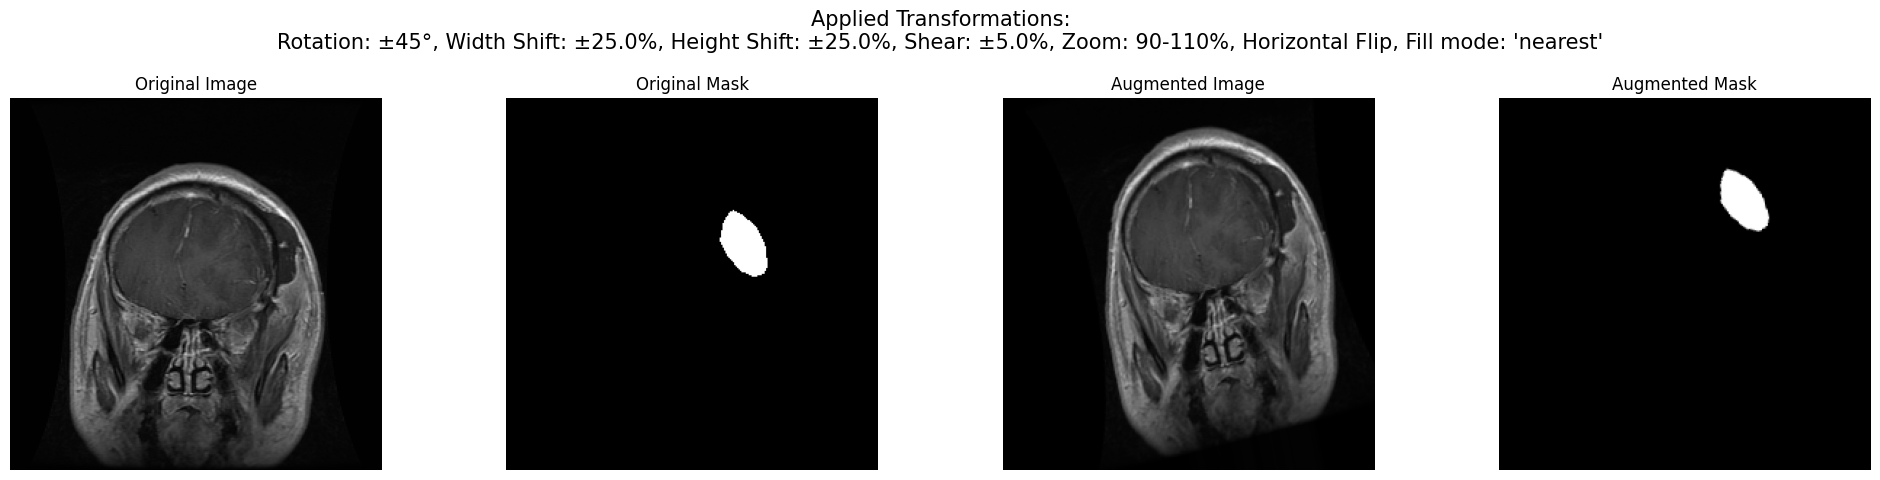

Checking first batch output:
Augmented image batch shape is correct: (8, 256, 256, 1)
Augmented mask batch shape is correct: (8, 256, 256, 3)


In [566]:
# Data Augmentation (optional, recommended)

is_augmented = True # activate augmentation Y/N?

# func to indicate whether or not augmentation (and its params) should be applied via boolean 'augment'
def get_augmentation_params(is_augmented):
    if is_augmented:                    # will augment
        return {
            'rotation_range': 45,       # rotate left-right by x degrees (0-360 degrees max, 0-90 typical)
            'width_shift_range': 0.25,  # shift horizontally ( 10% shift up of total img width) -> simulates subject off center
            'height_shift_range': 0.25, # shift vertically ( 10% shift up of total img height) -> simulates subject off center
            'shear_range': 0.05,        # change angle of looking at target (0-25 degrees)
            'zoom_range': [0.9, 1.1],   # add zoom to image -> simulates viewing target from closer/farther away; 0.9 = 90% original image shown so very zoomed out to 110% of image shown so zoomed in
            'horizontal_flip': True,    # yes/no flipped horizontally -> effective for images not greatly affected by flipped orientation e.g. landscape vs number
            'fill_mode': 'nearest'      # directs how to fill new pixels following a rotations/shift transformation
        }
    else:
        return {'fill_mode': 'nearest'} # won't augment

# create one generator for both images and masks to keep everythign synched
def create_augmentation_generator(images, masks, batch_size, seed, apply_augmentation=True):
    if apply_augmentation:
        augmentation_params = get_augmentation_params(True)
    else:
        augmentation_params = {'fill_mode': 'nearest'}  # Minimal transformation

    augmentor = ImageDataGenerator(**augmentation_params)

    combined = np.concatenate((images, masks), axis=-1) # concatenate images and masks - keep synched for this step
    generator = augmentor.flow(
        combined,
        batch_size=batch_size,
        seed=seed,
        shuffle=False # keep shuffling off to maintain original img for comparison with augmented img
    )

    while True:
        combined_batch = next(generator)
        images_batch = combined_batch[..., :images.shape[-1]]
        masks_batch = combined_batch[..., images.shape[-1]:]

        if masks_batch.shape == (None, 256, 256, 3) and images_batch.shape == (None, 256, 256, 1):
            tf.print("TIME TO TESTIFY: Augmentation step")
                    
        yield (images_batch, masks_batch)

original_generator = create_augmentation_generator(images_train, masks_train, batch_size, seed, apply_augmentation=False)
augmented_generator = create_augmentation_generator(images_train, masks_train, batch_size, seed, apply_augmentation=True)

# for development ONLY -> use visualizations to verify augmentation went smoothly/images are acceptable

def compare_original_and_augmented(original_gen, augmented_gen, num_samples=1):
    augmentation_params = get_augmentation_params(True)  # True because we need the full set for description
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5 * num_samples))

    # desription that's auto updated according to the parameters for on-sight interprtability
    # begin desc creation
    transformations = [
        f"Rotation: ±{augmentation_params['rotation_range']}°",
        f"Width Shift: ±{augmentation_params['width_shift_range']*100}%",
        f"Height Shift: ±{augmentation_params['height_shift_range']*100}%",
        f"Shear: ±{augmentation_params['shear_range']*100}%",
        f"Zoom: {int(augmentation_params['zoom_range'][0]*100)}-{int(augmentation_params['zoom_range'][1]*100)}%",
        "Horizontal Flip" if augmentation_params['horizontal_flip'] else "No Horizontal Flip",
        f"Fill mode: '{augmentation_params['fill_mode']}'"
    ]
    transformation_description = "Applied Transformations:\n" + ", ".join(transformations)
    fig.suptitle(transformation_description, fontsize=15) # added as header
    # end desc creation
    
    if num_samples == 1:
        axes = axes.reshape(1, -1)  # debug check: keeps indexing intact, don't remove

    for i in range(num_samples):
        orig_images_batch, orig_masks_batch = next(original_gen)
        aug_images_batch, aug_masks_batch = next(augmented_gen)

        axes[i, 0].imshow(orig_images_batch[0, ..., 0], cmap='gray') # img 1 - original img
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(orig_masks_batch[0, ..., 0], cmap='gray') # img 2 - original mask
        axes[i, 1].set_title('Original Mask')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(aug_images_batch[0, ..., 0], cmap='gray') # img 3 - augmented img
        axes[i, 2].set_title('Augmented Image')
        axes[i, 2].axis('off')

        axes[i, 3].imshow(aug_masks_batch[0, ..., 0], cmap='gray') # img 4 - augmented mask
        axes[i, 3].set_title('Augmented Mask')
        axes[i, 3].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # make space for header
    plt.show()

compare_original_and_augmented(original_generator, augmented_generator, num_samples=1) # call the plots -> do the images look acceptable?

# DEBUG CHECK: do our post data-augmentation model inputs match the required dimension and shape for training?
def check_augmented_data_shape(images_train, masks_train, batch_size, is_augmented):
    if is_augmented:
        print("Checking first batch output:")
        generator = create_augmentation_generator(images_train, masks_train, batch_size, seed, apply_augmentation=True)
        sample_img_output, sample_mask_output = next(generator)
        
        assert sample_img_output.shape == (batch_size, images_train.shape[1], images_train.shape[2], images_train.shape[3]), \
            f"Augmented image shape mismatch. Expected: (batch_size, height, width, channels), Got: {sample_img_output.shape}"
        assert sample_mask_output.shape == (batch_size, masks_train.shape[1], masks_train.shape[2], masks_train.shape[3]), \
            f"Augmented mask shape mismatch. Expected: (batch_size, height, width, channels), Got: {sample_mask_output.shape}"
        print(f"Augmented image batch shape is correct: {sample_img_output.shape}")
        print(f"Augmented mask batch shape is correct: {sample_mask_output.shape}")
    else:
        print(f"Images shape: {images_train.shape}")
        print(f"Masks shape: {masks_train.shape}")
        assert images_train.shape[0] == masks_train.shape[0], "Mismatch in number of images and masks."
        print("Non-augmented data shapes are correct.")

check_augmented_data_shape(images_train, masks_train, batch_size, is_augmented)

Model Training
- save the model with the best validation (development) accuracy until now
- a checkpoint saves the model's current state, including its weights, so we can resume training later/ use model from a particular epoch
- have different checks for different loss functions/metrics
- might need to use legacy version of Adam optimizer located at tf.keras.optimizers.legacy.Adam if too slow training times
- recommended: reinitialize model before each training run to avoid potential carryover weights/biases from prior trainings
- trainings are executed both WITH and WITHOUT data augmentation to compare best model fit

Memory Pressure Alleviations
- keep batch size under 4 if run locally to alleviate pressure
- include early stopping if validation loss isn't improving after a x number of epochs (set via 'patience')
- consider removing some metrics from architecutre + tracking

In [567]:
# Define visual checks for DURING training EPOCHS to compare actual vs predicted masks

class VisualizeSegmentation(Callback):
  """
  Custom callback to visualize predicted masks and compare them with ground truth during training epochs.

  This callback is intended for debugging and monitoring purposes. Generally not recommended for
  regular training as it can slow down the process.

  Args:
      model: The Keras model being trained.
      validation_data: A tuple of (images, masks) representing the validation data.
      num_samples: Number of validation samples to visualize per epoch (default 1).
  """

  def __init__(self, model, validation_data, num_samples=1):
    super().__init__()
    self.model = model
    self.validation_data = validation_data
    self.num_samples = num_samples

  def on_epoch_end(self, epoch, logs=None):
    """
    Visualizes predicted masks and ground truth masks at the end of each training epoch.

    Args:
        epoch: The current epoch number.
        logs: (Optional) Dictionary of logs accumulated during training (not used here).
    """
    # Select random validation samples
    idxs = np.random.choice(len(self.validation_data[0]), self.num_samples, replace=False)
    images, masks = self.validation_data[0][idxs], self.validation_data[1][idxs]
    preds = self.model.predict(images)

    # Create a Matplotlib figure for visualization
    fig, axes = plt.subplots(self.num_samples, 2, figsize=(6, 3 * self.num_samples))

    for i, (mask, pred) in enumerate(zip(masks, preds)):
      # Access axes for individual sample plots
      if self.num_samples == 1:
        ax1, ax2 = axes
      else:
        ax1, ax2 = axes[i]

      # Plot ground truth mask
      ax1.imshow(mask[:, :, 0], cmap='gray')
      ax1.set_title('True Mask')
      ax1.axis('off')

      # Plot predicted mask
      ax2.imshow(pred[:, :, 0], cmap='gray')
      ax2.set_title('Predicted Mask')
      ax2.axis('off')

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()

Validation data set: 20 images, 20 masks.
Validation data set: 20 images, 20 masks.
Training has begun. Metrics history initialized.
Epoch 1/3


/Users/elizabethnemeti/UNETENV/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Initial true_mask shape: (8, 256, 256, 3), dtype: <dtype: 'float32'>
Initial pred_mask shape: (8, 256, 256, 3), dtype: <dtype: 'float32'>
One-hot encoded true_mask shape: (8, 256, 256, 3)
Adjusted pred_mask shape: (8, 256, 256, 3)
True mask shape before assertion: (8, 256, 256, 3), Pred mask shape before assertion: (8, 256, 256, 3)
Categorical Cross-Entropy loss shape: (8, 256, 256)
Class 0 Dice loss: 0.9839840531349182
Class 1 Dice loss: 0.9999945759773254
Class 2 Dice loss: 0.9999938011169434
Final mean_loss shape: ()
Initial true_mask shape: (8, 256, 256, 3)
Initial pred_mask shape: (8, 256, 256, 3)
Class 0 accuracy: 0.38146400451660156
Class 1 accuracy: 0.0
Class 2 accuracy: 0.0
Mean accuracy: 0.12715467810630798
1/8 [==>...........................] - ETA: 12s - loss: 0.8986 - mean_accuracy_metric: 0.1272Initial true_mask shape: (8, 256, 256, 3), dtype: <dtype: 'float32'>
Initial pred_mask shape: (8, 256, 256, 3), dtype: <dtype: 'float32'>
One-hot encoded true_mask shape: (8, 256, 

/Users/elizabethnemeti/UNETENV/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 391ms/step


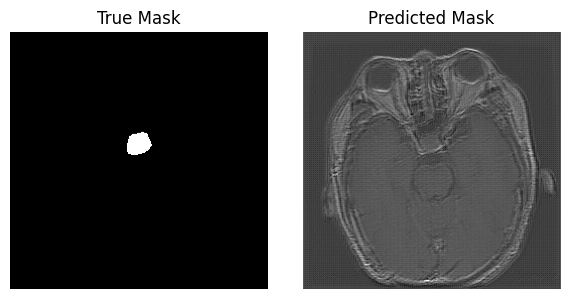

Validation data loaded: val_images shape (20, 256, 256, 1), true_mask shape (20, 256, 256, 3)
1/1 [==============================] - 0s 240ms/step
Predicted mask shape before argmax: (20, 256, 256, 3)
Predicted mask shape after argmax: (20, 256, 256)
Predicted mask shape after one_hot: (20, 256, 256, 3)
True mask shape after processing: (20, 256, 256, 3)
Initial true_mask shape: (20, 256, 256, 3), dtype: <dtype: 'float32'>
Initial pred_mask shape: (20, 256, 256, 3), dtype: <dtype: 'float32'>
One-hot encoded true_mask shape: (20, 256, 256, 3)
Adjusted pred_mask shape: (20, 256, 256, 3)
True mask shape before assertion: (20, 256, 256, 3), Pred mask shape before assertion: (20, 256, 256, 3)
Categorical Cross-Entropy loss shape: (20, 256, 256)
Class 0 Dice loss: 0.9258087277412415
Class 1 Dice loss: 0.9999988675117493
Class 2 Dice loss: 0.9999826550483704
Final mean_loss shape: ()
Epoch 1 metrics collected.

End of epoch 1
Layer: input_83, Output shape: [(None, 256, 256, 1)]
Layer: conv2d_

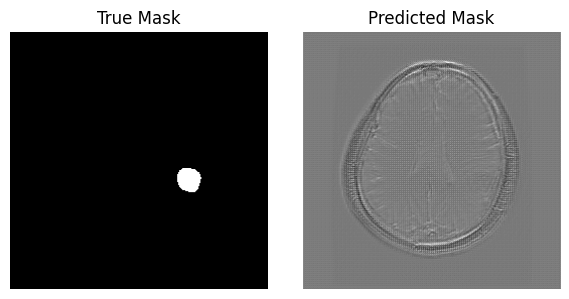

Validation data loaded: val_images shape (20, 256, 256, 1), true_mask shape (20, 256, 256, 3)
1/1 [==============================] - 0s 86ms/step
Predicted mask shape before argmax: (20, 256, 256, 3)
Predicted mask shape after argmax: (20, 256, 256)
Predicted mask shape after one_hot: (20, 256, 256, 3)
True mask shape after processing: (20, 256, 256, 3)
Initial true_mask shape: (20, 256, 256, 3), dtype: <dtype: 'float32'>
Initial pred_mask shape: (20, 256, 256, 3), dtype: <dtype: 'float32'>
One-hot encoded true_mask shape: (20, 256, 256, 3)
Adjusted pred_mask shape: (20, 256, 256, 3)
True mask shape before assertion: (20, 256, 256, 3), Pred mask shape before assertion: (20, 256, 256, 3)
Categorical Cross-Entropy loss shape: (20, 256, 256)
Class 0 Dice loss: 0.9625975489616394
Class 1 Dice loss: 0.9999987483024597
Class 2 Dice loss: 0.9999968409538269
Final mean_loss shape: ()
Epoch 2 metrics collected.

End of epoch 2
Layer: input_83, Output shape: [(None, 256, 256, 1)]
Layer: conv2d_1

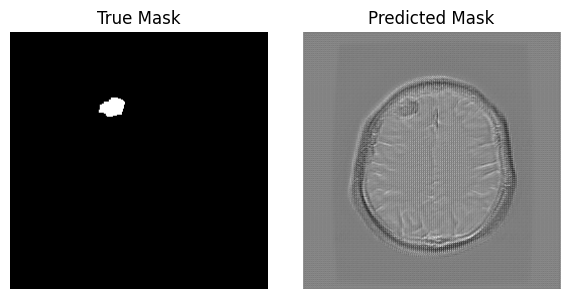

Validation data loaded: val_images shape (20, 256, 256, 1), true_mask shape (20, 256, 256, 3)
1/1 [==============================] - 0s 87ms/step
Predicted mask shape before argmax: (20, 256, 256, 3)
Predicted mask shape after argmax: (20, 256, 256)
Predicted mask shape after one_hot: (20, 256, 256, 3)
True mask shape after processing: (20, 256, 256, 3)
Initial true_mask shape: (20, 256, 256, 3), dtype: <dtype: 'float32'>
Initial pred_mask shape: (20, 256, 256, 3), dtype: <dtype: 'float32'>
One-hot encoded true_mask shape: (20, 256, 256, 3)
Adjusted pred_mask shape: (20, 256, 256, 3)
True mask shape before assertion: (20, 256, 256, 3), Pred mask shape before assertion: (20, 256, 256, 3)
Categorical Cross-Entropy loss shape: (20, 256, 256)
Class 0 Dice loss: 0.9667391777038574
Class 1 Dice loss: 0.999998927116394
Class 2 Dice loss: 0.9999955296516418
Final mean_loss shape: ()
Epoch 3 metrics collected.

End of epoch 3
Layer: input_83, Output shape: [(None, 256, 256, 1)]
Layer: conv2d_15

/Users/elizabethnemeti/UNETENV/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Categorical Cross-Entropy loss shape: (8, 256, 256)
Class 0 Dice loss: 0.9569379687309265
Class 1 Dice loss: 0.9999938011169434
Class 2 Dice loss: 0.9999951720237732
Final mean_loss shape: ()
Initial true_mask shape: (8, 256, 256, 3)
Initial pred_mask shape: (8, 256, 256, 3)
Class 0 accuracy: 0.24054718017578125
Class 1 accuracy: 0.0
Class 2 accuracy: 0.0
Mean accuracy: 0.08018239587545395
1/7 [===>..........................] - ETA: 5s - loss: 0.8894 - mean_accuracy_metric: 0.0802Initial true_mask shape: (8, 256, 256, 3), dtype: <dtype: 'float32'>
Initial pred_mask shape: (8, 256, 256, 3), dtype: <dtype: 'float32'>
One-hot encoded true_mask shape: (8, 256, 256, 3)
Adjusted pred_mask shape: (8, 256, 256, 3)
True mask shape before assertion: (8, 256, 256, 3), Pred mask shape before assertion: (8, 256, 256, 3)
Categorical Cross-Entropy loss shape: (8, 256, 256)
Class 0 Dice loss: 0.9670508503913879
Class 1 Dice loss: 0.9999937415122986
Class 2 Dice loss: 0.9999950528144836
Final mean_loss

/Users/elizabethnemeti/UNETENV/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 66ms/step


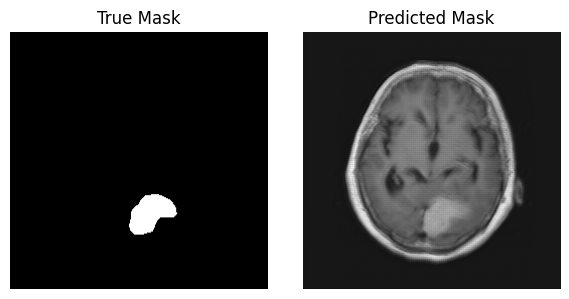

Validation data loaded: val_images shape (20, 256, 256, 1), true_mask shape (20, 256, 256, 3)
1/1 [==============================] - 0s 57ms/step
Predicted mask shape before argmax: (20, 256, 256, 3)
Predicted mask shape after argmax: (20, 256, 256)
Predicted mask shape after one_hot: (20, 256, 256, 3)
True mask shape after processing: (20, 256, 256, 3)
Initial true_mask shape: (20, 256, 256, 3), dtype: <dtype: 'float32'>
Initial pred_mask shape: (20, 256, 256, 3), dtype: <dtype: 'float32'>
One-hot encoded true_mask shape: (20, 256, 256, 3)
Adjusted pred_mask shape: (20, 256, 256, 3)
True mask shape before assertion: (20, 256, 256, 3), Pred mask shape before assertion: (20, 256, 256, 3)
Categorical Cross-Entropy loss shape: (20, 256, 256)
Class 0 Dice loss: 0.9337353706359863
Class 1 Dice loss: 0.99974125623703
Class 2 Dice loss: 0.9999987483024597
Final mean_loss shape: ()
Epoch 1 metrics collected.

End of epoch 1
Layer: input_82, Output shape: [(None, 256, 256, 1)]
Layer: conv2d_152

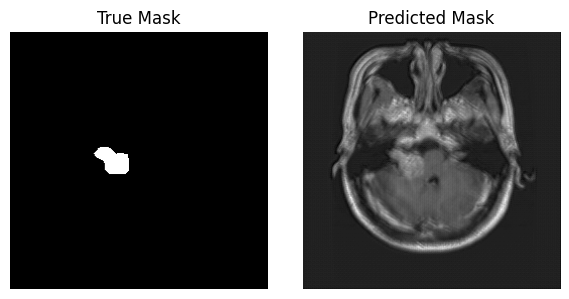

Validation data loaded: val_images shape (20, 256, 256, 1), true_mask shape (20, 256, 256, 3)
1/1 [==============================] - 0s 33ms/step
Predicted mask shape before argmax: (20, 256, 256, 3)
Predicted mask shape after argmax: (20, 256, 256)
Predicted mask shape after one_hot: (20, 256, 256, 3)
True mask shape after processing: (20, 256, 256, 3)
Initial true_mask shape: (20, 256, 256, 3), dtype: <dtype: 'float32'>
Initial pred_mask shape: (20, 256, 256, 3), dtype: <dtype: 'float32'>
One-hot encoded true_mask shape: (20, 256, 256, 3)
Adjusted pred_mask shape: (20, 256, 256, 3)
True mask shape before assertion: (20, 256, 256, 3), Pred mask shape before assertion: (20, 256, 256, 3)
Categorical Cross-Entropy loss shape: (20, 256, 256)
Class 0 Dice loss: 0.921204686164856
Class 1 Dice loss: 0.9996116757392883
Class 2 Dice loss: 0.9999988675117493
Final mean_loss shape: ()
Epoch 2 metrics collected.

End of epoch 2
Layer: input_82, Output shape: [(None, 256, 256, 1)]
Layer: conv2d_15

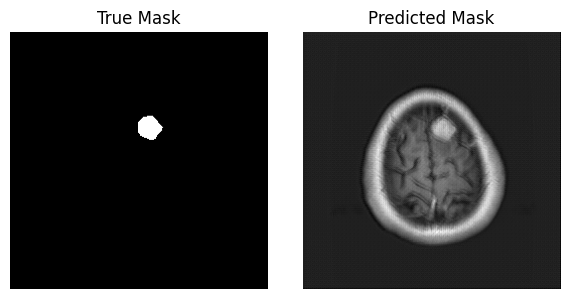

Validation data loaded: val_images shape (20, 256, 256, 1), true_mask shape (20, 256, 256, 3)
1/1 [==============================] - 0s 63ms/step
Predicted mask shape before argmax: (20, 256, 256, 3)
Predicted mask shape after argmax: (20, 256, 256)
Predicted mask shape after one_hot: (20, 256, 256, 3)
True mask shape after processing: (20, 256, 256, 3)
Initial true_mask shape: (20, 256, 256, 3), dtype: <dtype: 'float32'>
Initial pred_mask shape: (20, 256, 256, 3), dtype: <dtype: 'float32'>
One-hot encoded true_mask shape: (20, 256, 256, 3)
Adjusted pred_mask shape: (20, 256, 256, 3)
True mask shape before assertion: (20, 256, 256, 3), Pred mask shape before assertion: (20, 256, 256, 3)
Categorical Cross-Entropy loss shape: (20, 256, 256)
Class 0 Dice loss: 0.9143022298812866
Class 1 Dice loss: 0.9995555281639099
Class 2 Dice loss: 0.999998927116394
Final mean_loss shape: ()
Epoch 3 metrics collected.

End of epoch 3
Layer: input_82, Output shape: [(None, 256, 256, 1)]
Layer: conv2d_15

In [568]:
# Training Stage

# initialize both model instances
model_with_aug = unet()  
model_without_aug = unet() 

# defining checkpoints and patience (set between 10-20)
checkpoint_aug = ModelCheckpoint('best_model_aug.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
checkpoint_no_aug = ModelCheckpoint('best_model_no_aug.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min')

# defining ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=50, min_lr=1e-6, verbose=1)

# calling viz func
vis_callback_with_aug = VisualizeSegmentation(model_with_aug, (images_val, masks_val), num_samples=1)
vis_callback_without_aug = VisualizeSegmentation(model_without_aug, (images_val, masks_val), num_samples=1)

# initialize a MetricsCollectors for each model

metrics_collector_no_aug = MetricsCollector(num_classes=3)
metrics_collector_no_aug.set_validation_data((images_val, masks_val)) # ensure we collec the val set metrics too

metrics_collector_aug = MetricsCollector(num_classes=3)
metrics_collector_aug.set_validation_data((images_val, masks_val))

class CustomPrintCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEnd of epoch {epoch+1}")
        for layer in self.model.layers:
            if hasattr(layer, 'output_shape'):
                if layer.output_shape == (None, 256, 256, 3):
                    print("TIME TO TESTIFY: Shape changed to (None, 256, 256, 3)")
                print(f"Layer: {layer.name}, Output shape: {layer.output_shape}")

# training WITH NO data augmentation
history_without_aug = model_without_aug.fit(
    x=images_train, # updating weight in training
    y=masks_train,
    validation_data=(images_val, masks_val), # where validation happens (auto after each epoch), weights not updated here
    batch_size=batch_size, 
    epochs=3, # overfitting started after 2 for UNaugmented model
    callbacks=[checkpoint_no_aug, early_stopping, reduce_lr, vis_callback_without_aug, metrics_collector_no_aug, CustomPrintCallback()]
)

# training WITH data augmentation
history_with_aug = model_with_aug.fit(
    augmented_generator,
    steps_per_epoch=len(images_train) // batch_size,
    validation_data=(images_val, masks_val), # where validation happens (auto after each epoch)
    epochs=3, # overfitting started after 3 for augmented model
    callbacks=[checkpoint_aug, early_stopping, reduce_lr, vis_callback_with_aug, metrics_collector_aug, CustomPrintCallback()]
)

# Access metrics for model without augmentation
metrics_df_no_aug = metrics_collector_no_aug.metrics_history

# Access metrics for model with augmentation
metrics_df_aug = metrics_collector_aug.metrics_history

Confusion Matrix

- calculates the counts of true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN) based on predicted and true labels for each class
- need actual predictions of the model on the training and validation datasets, not auto stored so we need to generate them and store them
- since we have a multi-class problem, the CM must be multiplied by the number of classes we have i.e. 3x3

1/1 [==============================] - 0s 45ms/step


/Users/elizabethnemeti/UNETENV/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 27ms/step


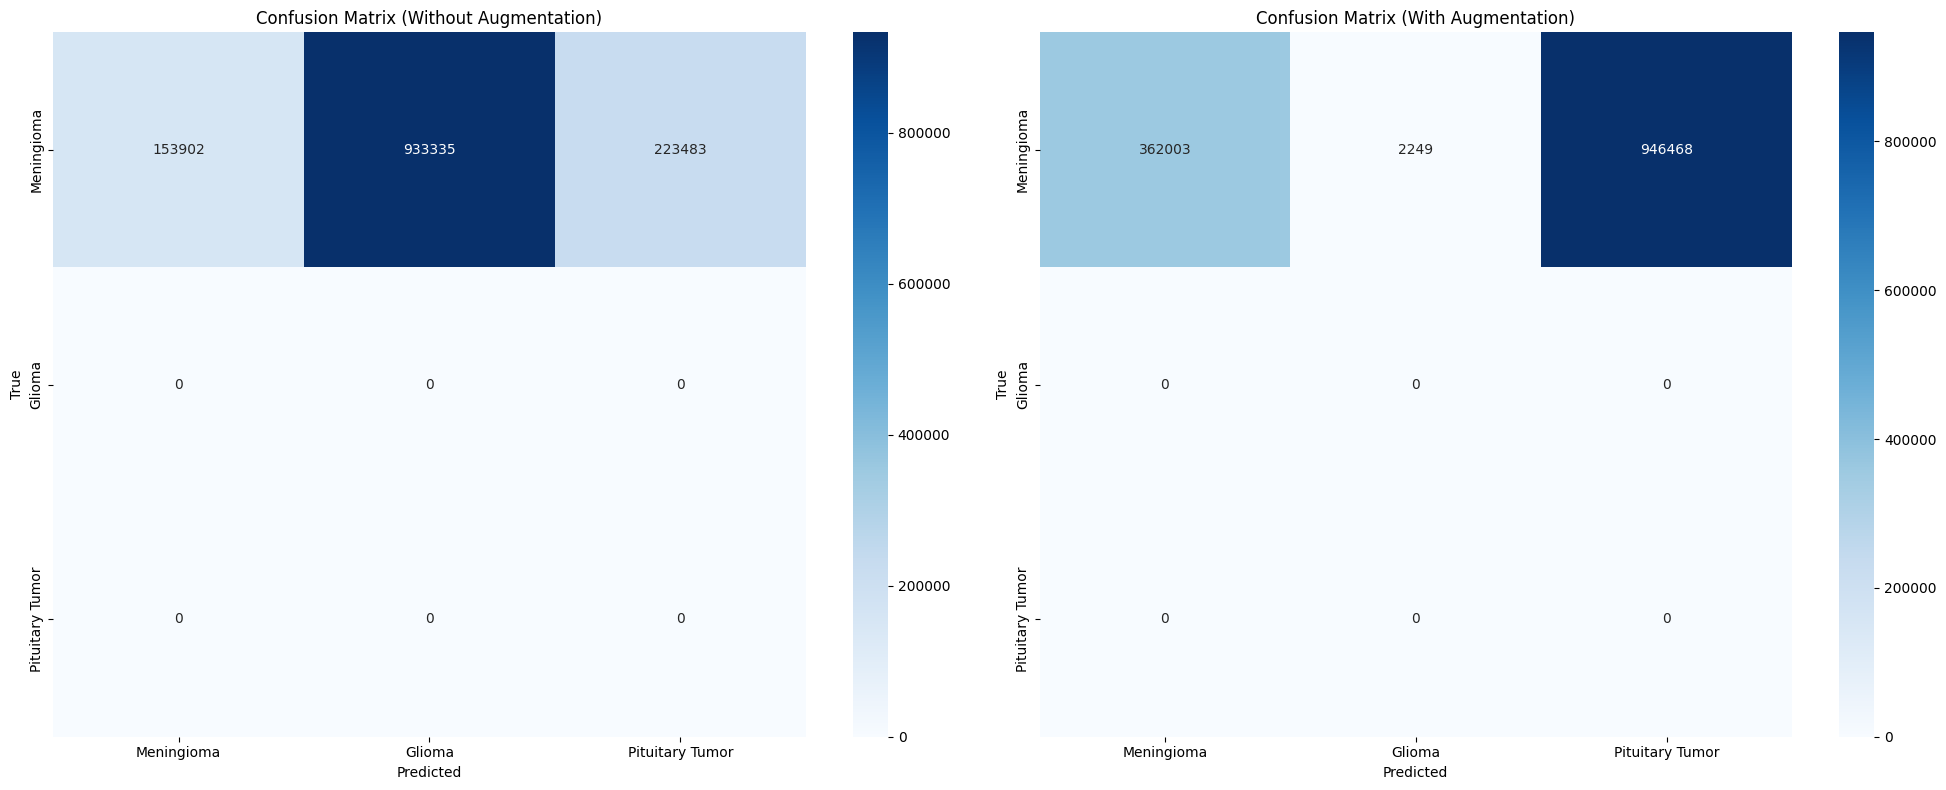

In [570]:
# get predictions for CM
def get_predictions(model, images):
    preds = model.predict(images)
    preds_classes = np.argmax(preds, axis=-1)
    return preds_classes

def get_true_classes(masks):
    return np.argmax(masks, axis=-1)

def plot_confusion_matrices(true_classes, pred_classes_no_aug, pred_classes_aug, class_names):
    cm_no_aug = confusion_matrix(true_classes.flatten(), pred_classes_no_aug.flatten())
    cm_aug = confusion_matrix(true_classes.flatten(), pred_classes_aug.flatten())
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    sns.heatmap(cm_no_aug, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[0])
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')
    axes[0].set_title('Confusion Matrix (Without Augmentation)')
    
    sns.heatmap(cm_aug, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[1])
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')
    axes[1].set_title('Confusion Matrix (With Augmentation)')
    
    plt.tight_layout()
    plt.show()

class_names = ['Meningioma', 'Glioma', 'Pituitary Tumor']

# grab true and predicted classes for validation set
true_classes = get_true_classes(masks_val)
pred_classes_no_aug = get_predictions(model_without_aug, images_val)
pred_classes_aug = get_predictions(model_with_aug, images_val)

plot_confusion_matrices(true_classes, pred_classes_no_aug, pred_classes_aug, class_names)

In [574]:
# DEBUG tool
print(history_without_aug.history.keys())
print(history_with_aug.history.keys())

dict_keys(['loss', 'mean_accuracy_metric', 'val_loss', 'val_mean_accuracy_metric', 'lr', 'epoch', 'mean_accuracy', 'class_0_accuracy', 'class_1_accuracy', 'class_2_accuracy', 'mean_loss', 'mean_dice_coef', 'mean_iou', 'class_0_dice_coef', 'class_0_iou', 'class_1_dice_coef', 'class_1_iou', 'class_2_dice_coef', 'class_2_iou'])
dict_keys(['loss', 'mean_accuracy_metric', 'val_loss', 'val_mean_accuracy_metric', 'lr', 'epoch', 'mean_accuracy', 'class_0_accuracy', 'class_1_accuracy', 'class_2_accuracy', 'mean_loss', 'mean_dice_coef', 'mean_iou', 'class_0_dice_coef', 'class_0_iou', 'class_1_dice_coef', 'class_1_iou', 'class_2_dice_coef', 'class_2_iou'])


PLOT 1: Compare Performance (mean class accuracy & mean class loss) For Non-Agumented & Augmented Models

- compares mean loss and mean accuracy AKA mean performance of the 3 classes
- compares training vs validation curves
- compares model with/without data augmentation

(observing combined loss and accuracy metrics are for checking the GENERAL performance of the DL model)

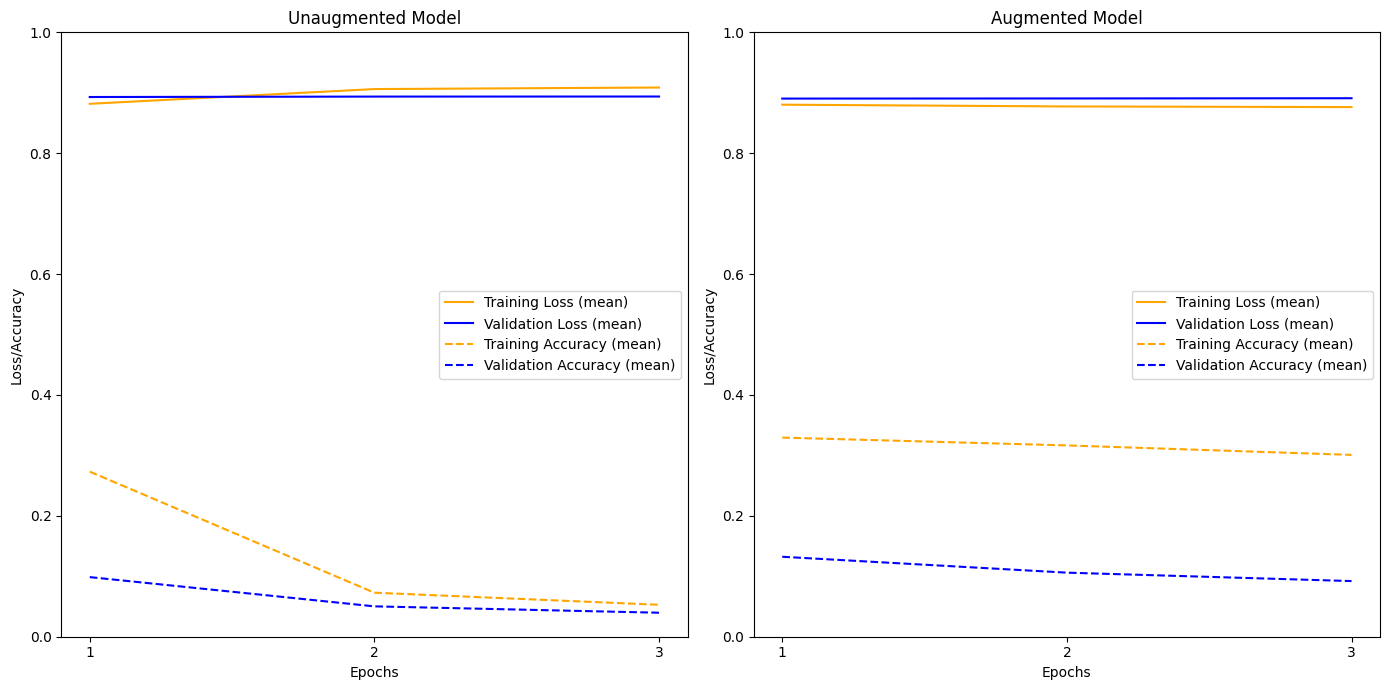

In [591]:
loss_with_aug = history_with_aug.history['mean_loss']
val_loss_with_aug = history_with_aug.history['val_loss']
accuracy_with_aug = history_with_aug.history['mean_accuracy']
val_accuracy_with_aug = history_with_aug.history['val_mean_accuracy_metric']

loss_without_aug = history_without_aug.history['mean_loss']
val_loss_without_aug = history_without_aug.history['val_loss']
accuracy_without_aug = history_without_aug.history['mean_accuracy']
val_accuracy_without_aug = history_without_aug.history['val_mean_accuracy_metric']

epochs = range(1, len(loss_with_aug) + 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# unaugmented model
ax1.plot(epochs, loss_without_aug, color="orange", linestyle="-", label='Training Loss (mean)')
ax1.plot(epochs, val_loss_without_aug, color="blue", linestyle="-", label='Validation Loss (mean)')
ax1.plot(epochs, accuracy_without_aug, color="orange", linestyle="--", label='Training Accuracy (mean)')
ax1.plot(epochs, val_accuracy_without_aug, color="blue", linestyle="--", label='Validation Accuracy (mean)')
ax1.set_title('Unaugmented Model')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss/Accuracy')
ax1.set_ylim(0, 1)
ax1.set_xticks(epochs) 
ax1.legend()

# augmented model
ax2.plot(epochs, loss_with_aug, color="orange", linestyle="-", label='Training Loss (mean)')
ax2.plot(epochs, val_loss_with_aug, color="blue", linestyle="-", label='Validation Loss (mean)')
ax2.plot(epochs, accuracy_with_aug, color="orange", linestyle="--", label='Training Accuracy (mean)')
ax2.plot(epochs, val_accuracy_with_aug, color="blue", linestyle="--", label='Validation Accuracy (mean)')
ax2.set_title('Augmented Model')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss/Accuracy')
ax2.set_ylim(0, 1)  
ax2.set_xticks(epochs) 
ax2.legend()

plt.tight_layout()
plt.show()

PLOT 2: Compare Performance (individual class combined loss & accuracy) for Non-Agumented & Augmented Models

- compares individual losses and individual accuracies AKA individual performance of each 3 classes
- compares training vs validation curves
- compares model with/without data augmentation 
- primarily for debugging, recommended

(observing combined loss and accuracy metrics are for checking the GENERAL performance of the DL model)

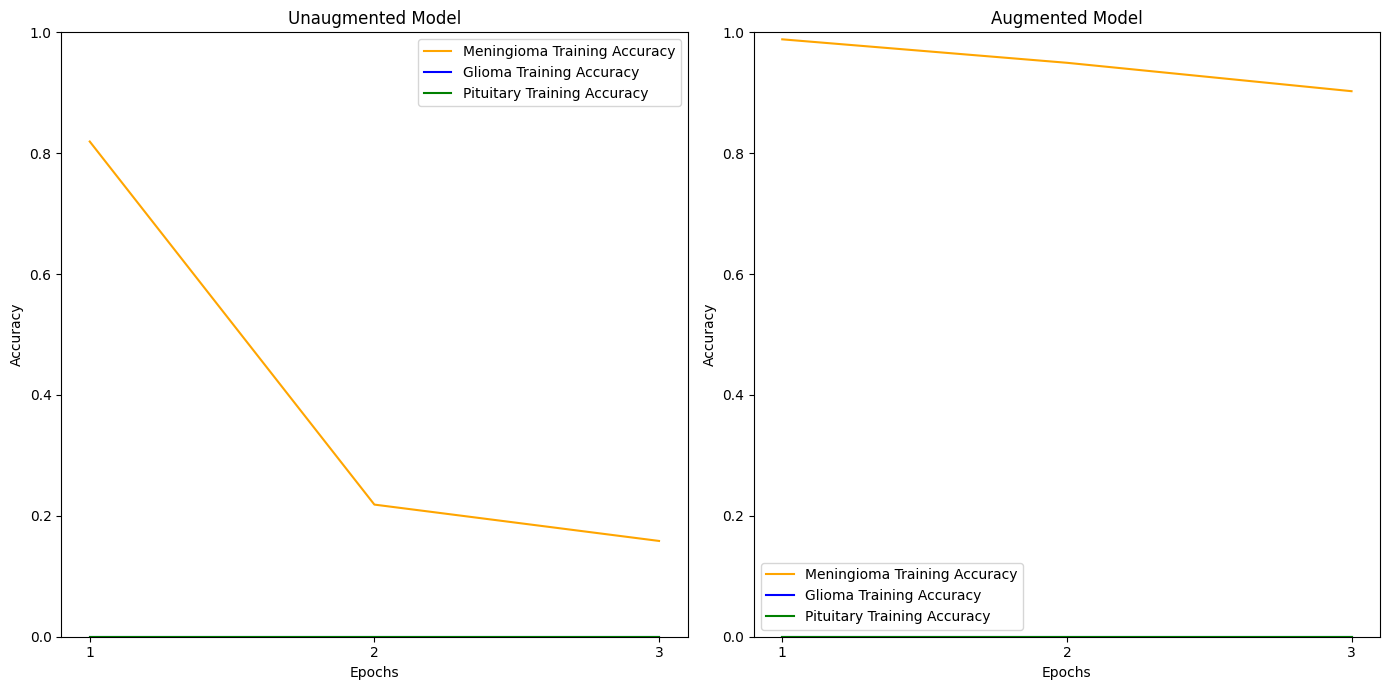

In [593]:
train_acc_class_0_with_aug = history_with_aug.history['class_0_accuracy']
train_acc_class_1_with_aug = history_with_aug.history['class_1_accuracy']
train_acc_class_2_with_aug = history_with_aug.history['class_2_accuracy']

train_acc_class_0_without_aug = history_without_aug.history['class_0_accuracy']
train_acc_class_1_without_aug = history_without_aug.history['class_1_accuracy']
train_acc_class_2_without_aug = history_without_aug.history['class_2_accuracy']

epochs = range(1, len(train_acc_class_0_with_aug) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# unaugmented model
ax1.plot(epochs, train_acc_class_0_without_aug, color="orange", linestyle="-", label='Meningioma Training Accuracy')
ax1.plot(epochs, train_acc_class_1_without_aug, color="blue", linestyle="-", label='Glioma Training Accuracy')
ax1.plot(epochs, train_acc_class_2_without_aug, color="green", linestyle="-", label='Pituitary Training Accuracy')

ax1.set_title('Unaugmented Model')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1) 
ax1.set_xticks(epochs)
ax1.legend()

# augmented model
ax2.plot(epochs, train_acc_class_0_with_aug, color="orange", linestyle="-", label='Meningioma Training Accuracy')
ax2.plot(epochs, train_acc_class_1_with_aug, color="blue", linestyle="-", label='Glioma Training Accuracy')
ax2.plot(epochs, train_acc_class_2_with_aug, color="green", linestyle="-", label='Pituitary Training Accuracy')

ax2.set_title('Augmented Model')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 1)
ax2.set_xticks(epochs)
ax2.legend()

plt.tight_layout()
plt.show()

PLOT 3: Compare Performance (mean class Dice Loss & Jaccard Loss) For Non-Agumented & Augmented Models

- compares mean Dice loss and mean Jaccard Loss AKA mean performance of the 3 classes
- compares training vs validation curves
- compares model with/without data augmentation

(observing dice and jaccard metrics are for checking the QUALITY and ACCURACY performance of an IMAGE SEGMENTATION model specifically)

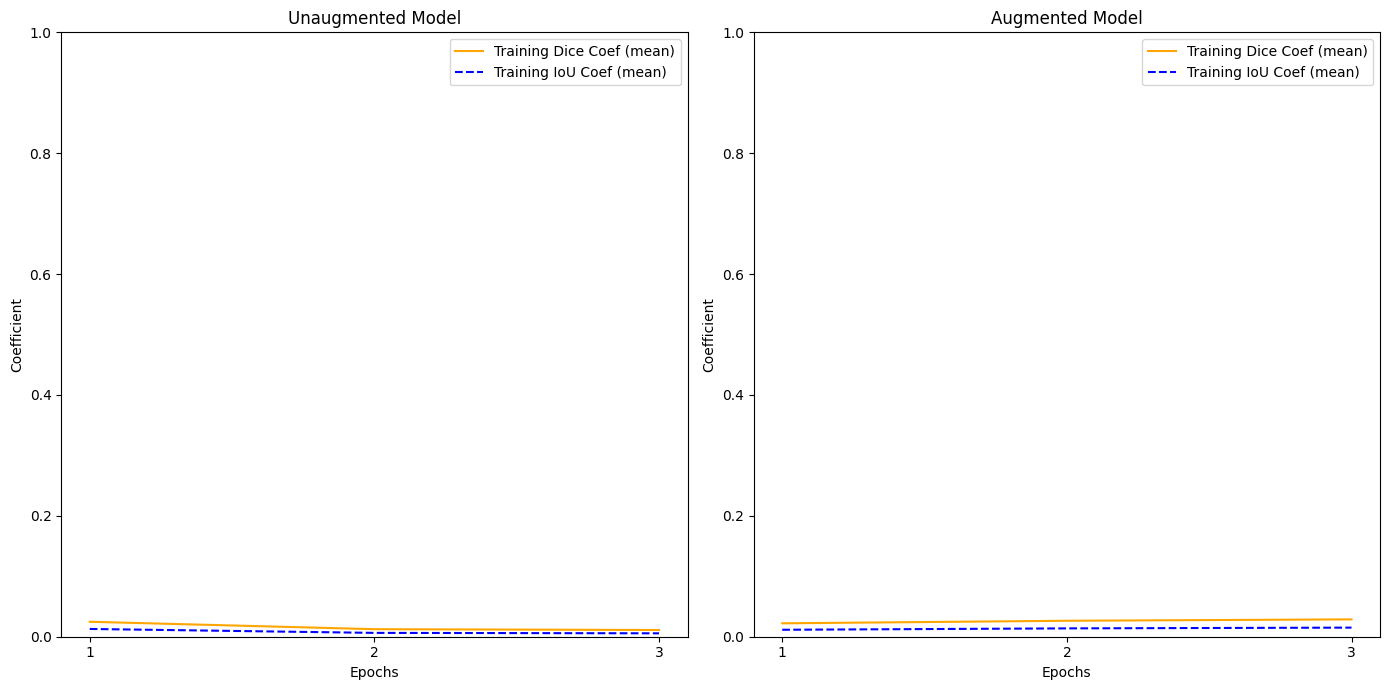

In [595]:
dice_with_aug = history_with_aug.history['mean_dice_coef']
iou_with_aug = history_with_aug.history['mean_iou']

dice_without_aug = history_without_aug.history['mean_dice_coef']
iou_without_aug = history_without_aug.history['mean_iou']

epochs = range(1, len(dice_with_aug) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# unaugmented model
ax1.plot(epochs, dice_without_aug, color="orange", linestyle="-", label='Training Dice Coef (mean)')
ax1.plot(epochs, iou_without_aug, color="blue", linestyle="--", label='Training IoU Coef (mean)')
ax1.set_title('Unaugmented Model')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Coefficient')
ax1.set_ylim(0, 1) 
ax1.set_xticks(epochs)
ax1.legend()

# augmented model
ax2.plot(epochs, dice_with_aug, color="orange", linestyle="-", label='Training Dice Coef (mean)')
ax2.plot(epochs, iou_with_aug, color="blue", linestyle="--", label='Training IoU Coef (mean)')
ax2.set_title('Augmented Model')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Coefficient')
ax2.set_ylim(0, 1)  
ax2.set_xticks(epochs)
ax2.legend()

plt.tight_layout()
plt.show()

PLOT 4: Compare Performance (individual class Dice Loss & Jaccard Loss) For Non-Agumented & Augmented Models

- compares individual Dice losses and individual Jaccard Losses AKA individual performance of each 3 classes
- compares training vs validation curves
- compares model with/without data augmentation
- primarily for debugging, recommended
r
(observing dice and jaccard metrics are for checking the QUALITY and ACCURACY performance of an IMAGE SEGMENTATION model specifically)

In [ ]:
def plot_classes_segmentation_performances(metrics_df_aug, metrics_df_no_aug, num_classes=3):
    epochs_aug = metrics_df_aug['epoch']
    epochs_no_aug = metrics_df_no_aug['epoch']
    
    class_colors = ['red', 'blue', 'green']
    class_labels = ['Class 1', 'Class 2', 'Class 3']

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # Augmented model metrics
    for i in range(num_classes):
        axs[0].plot(epochs_aug, metrics_df_aug[f'class_{i}_dice_coef'], label=f'{class_labels[i]} Dice Coef', color=class_colors[i], linestyle='-')
        axs[0].plot(epochs_aug, metrics_df_aug[f'class_{i}_iou'], label=f'{class_labels[i]} IoU', color=class_colors[i], linestyle='--')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Metrics')
    axs[0].set_title('Dice Coefficient and IoU per Class (Augmented)')
    handles, labels = axs[0].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    axs[0].legend(by_label.values(), by_label.keys())

    # Unaugmented model metrics
    for i in range(num_classes):
        axs[1].plot(epochs_no_aug, metrics_df_no_aug[f'class_{i}_dice_coef'], label=f'{class_labels[i]} Dice Coef', color=class_colors[i], linestyle='-')
        axs[1].plot(epochs_no_aug, metrics_df_no_aug[f'class_{i}_iou'], label=f'{class_labels[i]} IoU', color=class_colors[i], linestyle='--')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Metrics')
    axs[1].set_title('Dice Coefficient and IoU per Class (Unaugmented)')
    handles, labels = axs[1].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    axs[1].legend(by_label.values(), by_label.keys())

    plt.tight_layout()
    plt.show()

plot_classes_segmentation_performances(metrics_collector_aug.metrics_df, metrics_collector_no_aug.metrics_df, num_classes=3)

In [ ]:
- Keep Cell Active During Hypertuning to Break Off Pipeline Before Seeing Test Data
- Deactivate when Tuning Complete

Model Testing
- test model with the test set to see how well it performs on unseen data
- we want our coefficent high and our loss low
- the data augmented model should perform better on testing

Underfitting: both training and validation loss are high -> not learning effectively
Overfitting: training loss continues to decrease while validation loss begins to increase -> not generalizing well to validation data
Good fit: both losses decrease to a point of stability with a minimal gap between the two final loss values

# Testing Stage

# retrieve best model from training
# dont need to add standard metrics Recall, Precision, Accuracy just custom ones
best_model = load_model('best_model.h5', custom_objects={
    'combined_loss': combined_loss,
    'dice_coef': dice_coef,
    'iou_coef': iou_coef,
    'multi_class_specificity': multi_class_specificity(3)
})

test_results = best_model.evaluate(images_test, masks_test)

print(f"Test results - Loss: {test_results[0]} - Dice Coefficient: {test_results[1]} - IoU Coefficient: {test_results[2]}")

Visualize Final Segmentation Results (Predicted Masks)

- visualize jsut a subset of the segmentation results below
- save all segmentation result plots to a folder

plot_save_path = '/UNET_segmented_masks'  # local runs
# plot_save_path = '/mnt/beegfs/labs/mahmoudilab/nemeti/UNET_tests/UNET_segmented_masks'  # cluster runs

if not os.path.exists(plot_save_path):
    os.makedirs(plot_save_path)

# viz for x samples
num_random_samples = 3
idxs = np.random.choice(len(images_test), num_random_samples, replace=False)

selected_preds = best_model.predict(images_test[idxs]) # make prediction

# plots for predications compared to true masks/images
for i, idx in enumerate(idxs):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(images_test[idx].squeeze(), cmap='gray')
    axs[0].set_title('Test Image')
    axs[1].imshow(masks_test[idx].squeeze(), cmap='gray')
    axs[1].set_title('True Mask')
    axs[2].imshow(selected_preds[i].squeeze(), cmap='gray')
    axs[2].set_title('Predicted Mask')
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# save all the rest of the plots (and amek them) in a folder
for idx in range(len(images_test)):
    pred = best_model.predict(images_test[idx:idx+1])[0].squeeze() # mask prediction

    # make the figures (skip the display)
    fig, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
    axs[0].imshow(images_test[idx].squeeze(), cmap='gray')
    axs[0].set_title('Test Image')
    axs[1].imshow(masks_test[idx].squeeze(), cmap='gray')
    axs[1].set_title('True Mask')
    axs[2].imshow(pred, cmap='gray')
    axs[2].set_title('Predicted Mask')
    for ax in axs:
        ax.axis('off')

    fig.savefig(os.path.join(plot_save_path, f'visualization_{idx}.png'))
    plt.close(fig) 

print(f"Saved {len(images_test)} visualization plots to: {plot_save_path}")

Performance Plots for Loss & Metrics

- one plot per average score for each metric
- 28 plots (7x4) where
    - 7 metrics =  Dice Coef, IoU Coef, Accuracy, Recall, Precision, Specificity, Loss
    - 4 variables = classes average, tumor class 1, tumor class 2, tumor class 3

Reminder: labels 1, 2, and 3 correspond to meningioma, glioma, and pituitary tumor respectively

# Performance Plots for Loss & Metrics

history_dict = history.history
print(history.history.keys()) # make sure keys match!
print(history_dict)

epochs = range(1, len(history_dict['loss']) + 1) # sets x-axis to epochs correctly

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Training and Validation Metrics', fontsize=16)

# Dice Coefficient
axs[0, 0].plot(epochs, history_dict['dice_coef'], label='Train Dice Coef')
axs[0, 0].plot(epochs, history_dict['val_dice_coef'], label='Val Dice Coef')
axs[0, 0].set_title('Dice Coefficient')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Dice Coef')
axs[0, 0].legend()

# IoU
axs[0, 1].plot(epochs, history_dict['iou_coef'], label='Train IoU')
axs[0, 1].plot(epochs, history_dict['val_iou_coef'], label='Val IoU')
axs[0, 1].set_title('IoU Coefficient')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('IoU')
axs[0, 1].legend()

# Accuracy
axs[0, 2].plot(epochs, history_dict['accuracy'], label='Train Accuracy')
axs[0, 2].plot(epochs, history_dict['val_accuracy'], label='Val Accuracy')
axs[0, 2].set_title('Accuracy')
axs[0, 2].set_xlabel('Epochs')
axs[0, 2].set_ylabel('Accuracy')
axs[0, 2].legend()

# Recall/Sensitivity
axs[1, 0].plot(epochs, history_dict['my_recall'], label='Train Recall')  
axs[1, 0].plot(epochs, history_dict['val_my_recall'], label='Val Recall')  
axs[1, 0].set_title('Recall')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Recall')
axs[1, 0].legend()

# Precision
axs[1, 1].plot(epochs, history_dict['my_precision'], label='Train Precision')  
axs[1, 1].plot(epochs, history_dict['val_my_precision'], label='Val Precision') 
axs[1, 1].set_title('Precision')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Precision')
axs[1, 1].legend()

# Specificity
axs[1, 2].plot(epochs, history_dict['multi_class_specificity'], label='Train Specificity')  
axs[1, 2].plot(epochs, history_dict['val_multi_class_specificity'], label='Val Specificity')  
axs[1, 2].set_title('Specificity')
axs[1, 2].set_xlabel('Epochs')
axs[1, 2].set_ylabel('Specificity')
axs[1, 2].legend()

plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

# keeping Loss separate
plt.figure(figsize=(6, 4))
plt.plot(epochs, history_dict['loss'], label='Train Loss')
plt.plot(epochs, history_dict['val_loss'], label='Val Loss')
plt.title('Model Combined Loss')
plt.xlabel('Epochs')
plt.ylabel('Combined Loss')
plt.legend()
plt.show()